[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/username/repo/blob/branch/notebook.ipynb)


In [1]:
!git clone https://github.com/R-Goomer/SAM2_Gcode

Cloning into 'SAM2_Gcode'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 35 (delta 11), reused 18 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 3.91 MiB | 13.31 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [7]:
# !pip install -q supervision jupyter_bbox_widget
# !pip install torch torchvision numpy matplotlib opencv-python
# import sys
# !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything-2.git'

!mkdir -p checkpoints/
!wget -P checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt
!pip install -r /content/SAM2_Gcode/requirements.txt

--2024-08-19 03:12:48--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.51, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 897952466 (856M) [application/vnd.snesdev-page-table]
Saving to: ‘checkpoints/sam2_hiera_large.pt’

sam2_hiera_large.pt 100%[===================>] 856.35M   136MB/s    in 8.3s    

2024-08-19 03:12:56 (103 MB/s) - ‘checkpoints/sam2_hiera_large.pt’ saved [897952466/897952466]



In [1]:
import sys
import os

# Add the folder to the Python path
folder_path = '/content/SAM2_Gcode/'
sys.path.append(folder_path)


In [2]:
import cv2
import base64
import find_edges
import G_Code_Generation
import numpy as np
import matplotlib.pyplot as plt
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
# import importlib
# importlib.reload(find_edges)
# importlib.reload(G_Code_Generation)

IMAGE_PATH = "/content/SAM2_Gcode/sample_image/lab_glassware_1.jpeg"

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

/usr/local/lib/python3.10/dist-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [3]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

def show_mask(mask, ax, random_color=False, borders = True):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [8]:
sam2_checkpoint = "/content/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

predictor = SAM2ImagePredictor(sam2_model)

predictor.set_image(image_rgb)

In [9]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget(classes=['0','1'])
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(classes=['0', '1'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e37…

In [14]:
boxes = widget.bboxes
input_point = np.array([
    [
        box['x'],
        box['y']
    ] for box in boxes ])

input_label = np.array([ int(box['label']) for box in boxes ])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

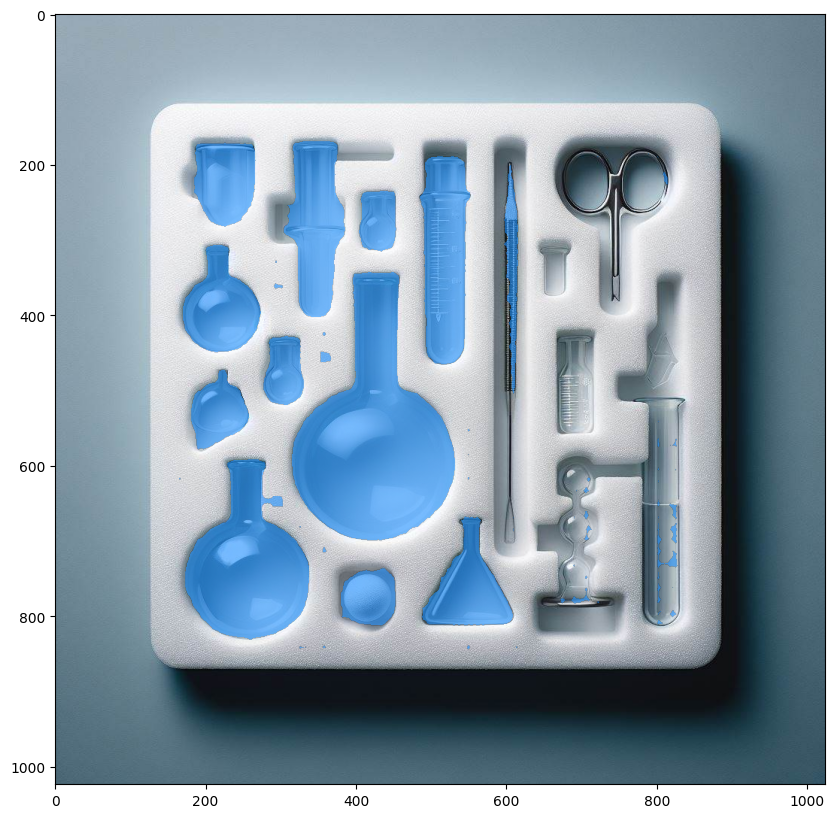

In [17]:
smooth_mask,approx_contours,output = find_edges.image_processing().get_contours(masks)
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
show_mask(smooth_mask, plt.gca(), random_color=True)

In [18]:
G_Code_Generation.GCodeGenerator().generate_from_contours(approx_contours)

# Gcode - https://ncviewer.com/

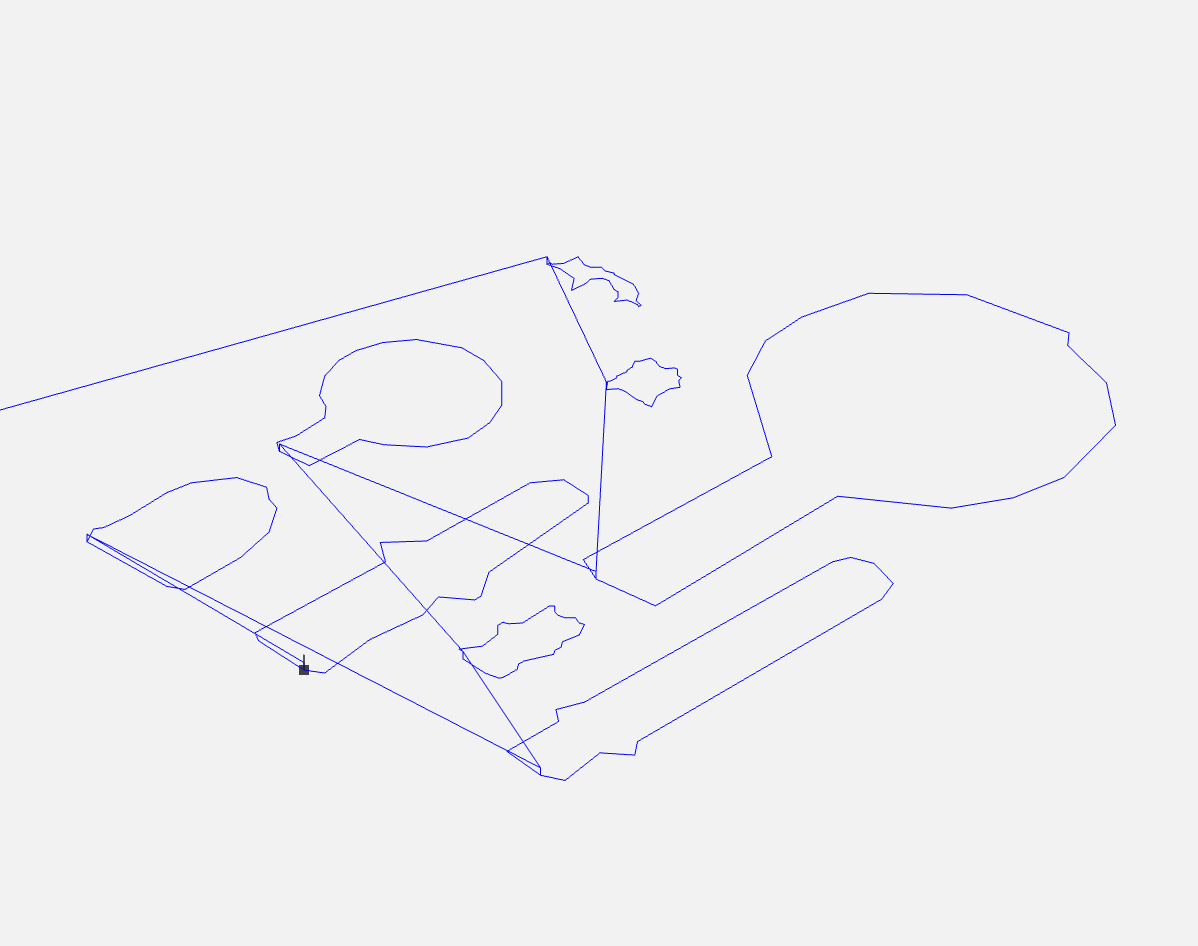